# II - Creation of the models

All the imports needed

In [ ]:
import numpy as np 
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os 
from tensorflow.keras import layers
from tensorflow.keras import models
import matplotlib.pyplot as plt 


## II.1 - Fetching the data 

In [ ]:

X = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/input_persistence.npy')
Y = np.load('/Users/lacottepaul/Desktop/weather-nowcasting/data/target_persistence.npy')


## II.2 - Persistence model 

Then we can create the persistence model 

In [3]:
Y_pred = X.copy()  # as Y ranges from t=1 to t=49 and X from t=0 to t=48 we can just say we want Y_pred = X

we can now save the prediction to use it in our evalution notebook 

In [6]:
np.save('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_pred.npy', Y_pred)
np.save('/Users/lacottepaul/Desktop/weather-nowcasting/data/Y_true.npy', Y)

## II.3 - Basic Unet 

Now that we have a baseline model, let's try to implement a Unet: using double conv, an down block and a up block. 

In [ ]:
def double_conv(x, filters):
    """
    Double convolution 3x3 + BN + ReLU
    """
    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x

def build_unet(input_shape=(128, 128, 3), base_filters=64):
    """
    U-Net model for 3-frame radar input → 1-frame output
    """

    inputs = layers.Input(shape=input_shape)  # (H, W, 3)

    # Encoder
    c1 = double_conv(inputs, base_filters)           # 64
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = double_conv(p1, base_filters * 2)           # 128
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = double_conv(p2, base_filters * 4)           # 256
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = double_conv(p3, base_filters * 8)           # 512

    # Decoder
    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])
    c5 = double_conv(u1, base_filters * 4)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = double_conv(u2, base_filters * 2)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])
    c7 = double_conv(u3, base_filters)

    # Sortie : 1 canal (prédiction radar t+0)
    outputs = layers.Conv2D(1, (1, 1), activation='linear')(c7)

    return models.Model(inputs, outputs)

2025-06-27 10:44:30.888357: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-27 10:44:32.780836: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751013873.588026  106845 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751013873.807932  106845 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751013875.672128  106845 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [ ]:
X = np.load('path/X_unet.npy')
Y = np.load('path/Y_unet.npy')

print(X.shape, Y.shape)

(47, 64, 64, 3) (47, 64, 64, 1)


In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [78]:
model = build_unet(input_shape=(X.shape[1], X.shape[2], 3))  # 3 canaux en entrée
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_210 (Conv2D) │ (None, 64, 64,    │      1,728 │ input_layer_14[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_210[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_196 (ReLU)    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_211 (Conv2D) │ (None, 64, 64,    │     36,864 │ re_lu_196[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_211[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_197 (ReLU)    │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_42    │ (None, 32, 32,    │          0 │ re_lu_197[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_212 (Conv2D) │ (None, 32, 32,    │     73,728 │ max_pooling2d_42… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_212[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_198 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_213 (Conv2D) │ (None, 32, 32,    │    147,456 │ re_lu_198[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        512 │ conv2d_213[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_199 (ReLU)    │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_43    │ (None, 16, 16,    │          0 │ re_lu_199[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_214 (Conv2D) │ (None, 16, 16,    │    294,912 │ max_pooling2d_43… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │      1,024 │ conv2d_214[0][0]

 Total params: 7,791,361 (29.72 MB)

 Trainable params: 7,785,729 (29.70 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [ ]:
save_dir = "path/data"
os.makedirs(save_dir, exist_ok=True)

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=1,
    batch_size=5,
    callbacks=[
        tf.keras.callbacks.ModelCheckpoint(os.path.join(save_dir, "Unet_simple.h5"), save_best_only=True)
    ]
)

np.save(os.path.join(save_dir, "Unet_simple_history.npy"), history.history)


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - loss: 1.7421 - mae: 0.9564

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 527ms/step - loss: 1.6617 - mae: 0.9311 - val_loss: 0.0670 - val_mae: 0.1382


If we do anything higher than 1 epoch with as little data as we have we overfit and the data predicted lose all physical sense. 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step


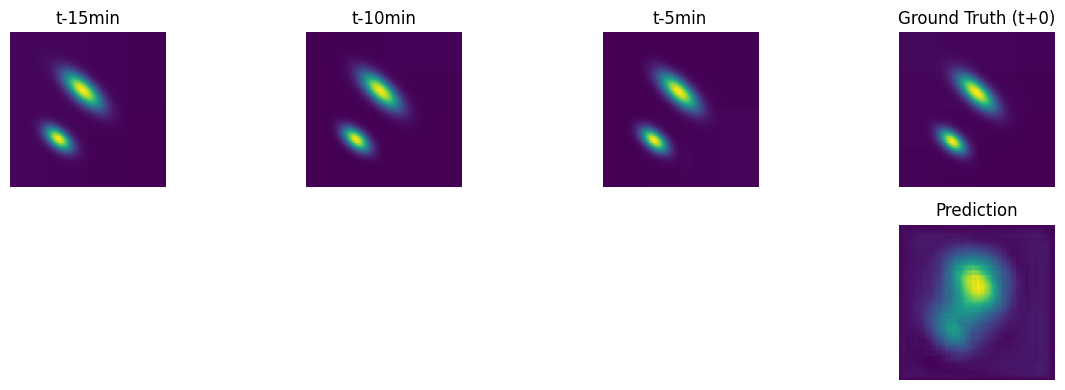

In [80]:

i = 0  #test index
pred = model.predict(X_val[i:i+1])[0, ..., 0]
truth = Y_val[i, ..., 0]
input_frames = X_val[i]

plt.figure(figsize=(12, 4))

for j in range(3):
    plt.subplot(2, 4, j+1)
    plt.imshow(input_frames[..., j], cmap='viridis')
    plt.title(f"t-{15 - j*5}min")
    plt.axis('off')


plt.subplot(2, 4, 4)
plt.imshow(truth, cmap='viridis')
plt.title("Ground Truth (t+0)")
plt.axis('off')


plt.subplot(2, 4, 8)
plt.imshow(pred, cmap='viridis')
plt.title("Prediction")
plt.axis('off')

plt.tight_layout()
plt.show()

The solution here might be to apply data augmention but we need to make sure to not lose the physical sense (i.e no rotation/flip). As we are doing only one epoch there is no need here for any loss visualisation. 

## II.4 - State of the art Unet  

Lets try and use: **Shreya Agrawal, Luke Barrington, Carla Bromberg, John Burge, Cenk Gazen, Jason Hickey.** Machine Learning for Precipitation Nowcasting from Radar Images. https://doi.org/10.48550/arXiv.1912.12132 


To implement the Unet available at: https://github.com/fabarca/google_unet_nowcast/blob/main/model_unet_nowcast.py to our data and see what we have compared to the more'basic' Unet. 

In [88]:
def basic_block(input_layer, n_channels):
    residual = layers.Conv2D(n_channels, 1, padding="same")(input_layer)  # short_skip

    out_layer = layers.Conv2D(n_channels, 3, padding="same")(input_layer)
    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    out_layer = layers.add([out_layer, residual])  # Add back residual

    return out_layer


def down_block(input_layer, n_channels):
    residual = layers.Conv2D(n_channels, 1, strides=2, padding="same")(input_layer)  # short_skip

    out_layer = layers.BatchNormalization()(input_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)

    # **long_skip before pooling**
    long_skip = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    # then pooling for the block output
    out_pooled = layers.MaxPooling2D(2, strides=2, padding="same")(long_skip)

    out_pooled = layers.BatchNormalization()(out_pooled)
    out_pooled = layers.LeakyReLU(negative_slope=0.1)(out_pooled)

    out_pooled = layers.Conv2D(n_channels, 3, padding="same")(out_pooled)

    out_layer = layers.add([out_pooled, residual])  # Add back residual

    return out_layer, long_skip


def up_block(input_layer, long_skip, n_channels):
    # upsample input_layer (qui a moitié moins de résolution)
    upsampled = layers.UpSampling2D(2)(input_layer)

    # concat avec long_skip de même résolution
    out_layer = layers.concatenate([upsampled, long_skip], axis=-1)

    residual = layers.Conv2D(n_channels, 1, padding='same')(out_layer)  # short skip

    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)
    out_layer = layers.BatchNormalization()(out_layer)
    out_layer = layers.LeakyReLU(negative_slope=0.1)(out_layer)
    out_layer = layers.Conv2D(n_channels, 3, padding="same")(out_layer)

    out_layer = layers.add([out_layer, residual])  # Add back residual

    return out_layer


def get_model(height, width, channels, out_channels, is_classification=True):
    inputs = layers.Input(shape=(height, width, channels))

    basicx1 = basic_block(inputs, 32)

    downx2, downx2_skip = down_block(basicx1, 32)
    downx4, downx4_skip = down_block(downx2, 64)
    downx8, downx8_skip = down_block(downx4, 128)
    downx16, downx16_skip = down_block(downx8, 256)
    downx32, downx32_skip = down_block(downx16, 512)

    center = basic_block(downx32, 512)

    upx16 = up_block(center, downx32_skip, 512)
    upx8 = up_block(upx16, downx16_skip, 256)
    upx4 = up_block(upx8, downx8_skip, 128)
    upx2 = up_block(upx4, downx4_skip, 64)
    upx1 = up_block(upx2, downx2_skip, 32)

    if is_classification:
        outputs = layers.Conv2D(out_channels, 3, activation="softmax", padding="same")(upx1)
    else:
        outputs = layers.Conv2D(out_channels, 3, activation="linear", padding="same")(upx1)

    model = models.Model(inputs, outputs)

    return model


# Free up RAM if needed
tf.keras.backend.clear_session()

model = get_model(64, 64, 3, 1, is_classification=False)
model.summary(line_length=120)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer (InputLayer)          │ (None, 64, 64, 3)            │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_1 (Conv2D)                 │ (None, 64, 64, 32)           │               896 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization               │ (None, 64, 64, 32)           │               128 │ conv2d_1[0][0]            
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu (LeakyReLU)           │ (None, 64, 64, 32)           │                 0 │ batch_normalization[0][0] 
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_2 (Conv2D)                 │ (None, 64, 64, 32)           │             9,248 │ leaky_re_lu[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d (Conv2D)                   │ (None, 64, 64, 32)           │               128 │ input_layer[0][0]         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add (Add)                         │ (None, 64, 64, 32)           │                 0 │ conv2d_2[0][0], conv2d[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_1             │ (None, 64, 64, 32)           │               128 │ add[0][0]                 
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_1 (LeakyReLU)         │ (None, 64, 64, 32)           │                 0 │ batch_normalization_1[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_4 (Conv2D)                 │ (None, 64, 64, 32)           │             9,248 │ leaky_re_lu_1[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ max_pooling2d (MaxPooling2D)      │ (None, 32, 32, 32)           │                 0 │ conv2d_4[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ batch_normalization_2             │ (None, 32, 32, 32)           │               128 │ max_pooling2d[0][0]       
│ (BatchNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ leaky_re_lu_2 (LeakyReLU)         │ (None, 32, 32, 32)           │                 0 │ batch_normalization_2[0][0
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_5 (Conv2D)                 │ (None, 32, 32, 32)           │             9,248 │ leaky_re_lu_2[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ conv2d_3 (Conv2D)                 │ (None, 32, 32, 32)

 Total params: 20,911,233 (79.77 MB)

 Trainable params: 20,900,225 (79.73 MB)

 Non-trainable params: 11,008 (43.00 KB)

We can now try to train it

In [ ]:
X_unet = np.load('path/X_unet.npy')
Y_unet = np.load('path/Y_unet.npy')

print("X_unet shape:", X_unet.shape)  
print("Y_unet shape:", Y_unet.shape)  


model = get_model(height=X_unet.shape[1], 
                  width=X_unet.shape[2], 
                  channels=X_unet.shape[3], 
                  out_channels=Y_unet.shape[3], 
                  is_classification=False) 


model.compile(optimizer='adam', loss='mse', metrics=['mae'])  

history = model.fit(
    X_unet, 
    Y_unet, 
    batch_size=4,    
    epochs=10,        
    validation_split=0.2,
    shuffle=True
)

model.save('path/unet_model.h5')

X_unet shape: (47, 64, 64, 3)
Y_unet shape: (47, 64, 64, 1)
Epoch 1/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 16s 638ms/step - loss: 294.8262 - mae: 9.7445 - val_loss: 0.8152 - val_mae: 0.7153
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 29.1746 - mae: 3.6991 - val_loss: 80.7012 - val_mae: 7.0150
Epoch 3/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 3.6625 - mae: 1.4784 - val_loss: 29.6494 - val_mae: 4.2260
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7799 - mae: 1.0629 - val_loss: 9.3458 - val_mae: 2.4046
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.6630 - mae: 1.0484 - val_loss: 4.1296 - val_mae: 1.6674
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9775 - mae: 0.7568 - val_loss: 1.5819 - val_mae: 1.0499
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5105 - mae: 0.5509 - val_loss: 0.9661 - val_mae: 0.8374
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3689 - mae: 0.4686 - val_loss: 0.7281 - val_mae: 0.69

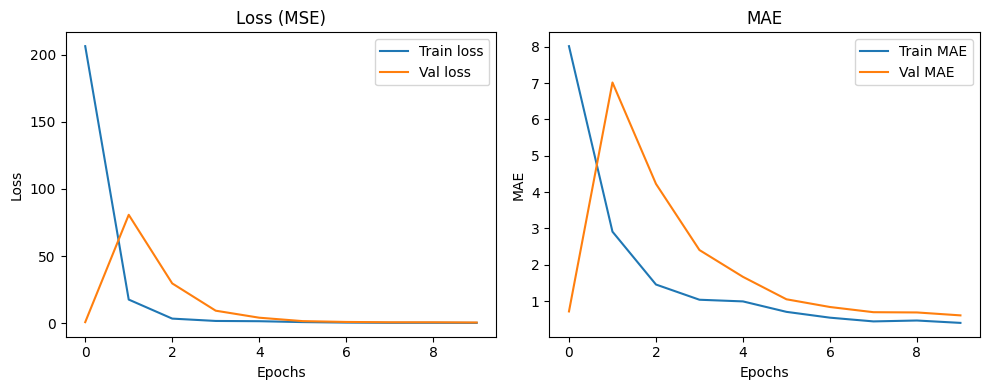

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.title("Loss (MSE)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title("MAE")
plt.xlabel("Epochs")
plt.ylabel("MAE")
plt.legend()

plt.tight_layout()
plt.show()